<a href="https://colab.research.google.com/github/shreyash-99/EVA8/blob/main/Session%204%20Assignment%202%20of%20n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target
1. Reduce overfitting by implementing Dropout
2. Make the model a little heavy by modifing the channel sizes and skeleton

In [58]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms

In [59]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081, ))])


In [60]:
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

In [61]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available" , cuda)

#for Reproducibilty
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# setting the dataloader arguments for both test and train data
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)

train_loader = torch.utils.data.DataLoader(train , **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA available True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


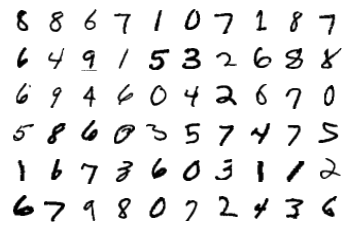

In [62]:
images,labels = next(iter(train_loader))
import numpy as np
import matplotlib.pyplot as plt

num_of_images = 60
for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap = 'gray_r')

# print(labels)


In [81]:
dropout_value = 0.1
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    ## INPUT BLOCK (BLOCK  1 )
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(dropout_value)   
    )# input - 28, output - 28
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(dropout_value)
    )#input - 28 , output - 28
    

    # TRANSITION BLOCK 
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = (1,1)),
        # nn.BatchNorm2d(8),
        # nn.ReLU()
    )# input - 28 , output - 28
    self.pool1 = nn.MaxPool2d(2, 2)
    # input 28, output - 14

    #  CONVOLUTION  BLOCK 2
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 8 , kernel_size = (3,3),padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU(),#input = 14 , output  = 14
        nn.Dropout(dropout_value)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),# input - 14 , output = 14
        nn.Dropout(dropout_value)
    )

    #   TRANSITION BLOCK 
    self.conv6 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = (1,1)),
        # nn.BatchNorm2d(8),
        # nn.ReLU() # input - 14, output - 14
    )
    self.pool2 = nn.MaxPool2d(2,2) #input 10, output 5

    #   CONVOLUTION BLOCK 3

    self.conv7 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 8 , kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU(),#input = 14, output = 7
        nn.Dropout(dropout_value)
    )
    self.conv8 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels = 16, kernel_size = (3,3), padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),#input = 7, output = 7
        nn.Dropout(dropout_value)
    )

    #     Transition Block
    self.conv9 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = (1,1)),
        # nn.BatchNorm2d(8),
        # nn.ReLU() # input - 7, output - 7
    )
    
    #      CONVOLUTION BLOCK 4

    self.conv10 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3)),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(dropout_value)
    )#input = 7, output 5
    self.conv11 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3)),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(dropout_value)
    )# input 5 , output 3

    self.conv12 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (3,3))
    )
    


  def forward(self, x ):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.pool1(x)

    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.pool2(x)

    x = self.conv7(x)
    x = self.conv8(x)
    x = self.conv9(x)
    # x = self.pool3(x)

    x = self.conv10(x)
    x = self.conv11(x)
    x = self.conv12(x)

    x = x.view(-1,10)
    return F.log_softmax(x, dim = -1)




In [82]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size = (1,28,28))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,168
       BatchNorm2d-6           [-1, 16, 28, 28]              32
              ReLU-7           [-1, 16, 28, 28]               0
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             136
        MaxPool2d-10            [-1, 8, 14, 14]               0
           Conv2d-11            [-1, 8, 14, 14]             584
      BatchNorm2d-12            [-1, 8, 14, 14]              16

In [89]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimiser, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    #get samples
    data, target = data.to(device), target.to(device)

    #init
    optimiser.zero_grad()

    #prediction
    y_pred = model(data)

    #calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    #Backpropagation
    loss.backward()
    optimiser.step()

    # update pbar - tqdm

    pred = y_pred.argmax(dim = 1, keepdim = True) # gets the index of the max log-probabilirty
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
  test_acc.append(100. * correct / len(test_loader.dataset))




In [90]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.35013487935066223 Batch_id=468 Accuracy=89.11: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]



Test set: Average loss: 0.1117, Accuracy: 9647/10000 (96.47%)

EPOCH: 1


Loss=0.09669745713472366 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]



Test set: Average loss: 0.0700, Accuracy: 9772/10000 (97.72%)

EPOCH: 2


Loss=0.0865863785147667 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]



Test set: Average loss: 0.0530, Accuracy: 9827/10000 (98.27%)

EPOCH: 3


Loss=0.03444383665919304 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]



Test set: Average loss: 0.0423, Accuracy: 9868/10000 (98.68%)

EPOCH: 4


Loss=0.08114390075206757 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]



Test set: Average loss: 0.0461, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.12626083195209503 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]



Test set: Average loss: 0.0374, Accuracy: 9875/10000 (98.75%)

EPOCH: 6


Loss=0.06966187804937363 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]



Test set: Average loss: 0.0355, Accuracy: 9883/10000 (98.83%)

EPOCH: 7


Loss=0.03103007562458515 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]



Test set: Average loss: 0.0490, Accuracy: 9854/10000 (98.54%)

EPOCH: 8


Loss=0.11881162971258163 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]



Test set: Average loss: 0.0381, Accuracy: 9888/10000 (98.88%)

EPOCH: 9


Loss=0.06233637407422066 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]



Test set: Average loss: 0.0337, Accuracy: 9894/10000 (98.94%)

EPOCH: 10


Loss=0.07006912678480148 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s]



Test set: Average loss: 0.0289, Accuracy: 9908/10000 (99.08%)

EPOCH: 11


Loss=0.015529781579971313 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]



Test set: Average loss: 0.0373, Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=0.055175915360450745 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]



Test set: Average loss: 0.0412, Accuracy: 9869/10000 (98.69%)

EPOCH: 13


Loss=0.013990357518196106 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]



Test set: Average loss: 0.0309, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.03938385844230652 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]



Test set: Average loss: 0.0265, Accuracy: 9909/10000 (99.09%)

EPOCH: 15


Loss=0.05305905640125275 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]



Test set: Average loss: 0.0293, Accuracy: 9903/10000 (99.03%)

EPOCH: 16


Loss=0.045497775077819824 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]



Test set: Average loss: 0.0287, Accuracy: 9907/10000 (99.07%)

EPOCH: 17


Loss=0.017669284716248512 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]



Test set: Average loss: 0.0264, Accuracy: 9912/10000 (99.12%)

EPOCH: 18


Loss=0.011132698506116867 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]



Test set: Average loss: 0.0314, Accuracy: 9904/10000 (99.04%)

EPOCH: 19


Loss=0.004340196959674358 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]



Test set: Average loss: 0.0302, Accuracy: 9905/10000 (99.05%)



Results
1. Parameters: 10.2k
2. Best Train Accuracy: 98.71
3. Best Test Accuracy: 99.12

Analysis
1. The model is underfitting as we increased the diffficulty by using dropout of 0.1, our mission of decreasing the difference between test and train accuracy was achieved.
2. A little over the required parameters which can reduced by introducing global average pooling layer. because of which number of parameters will reduce whichb we compensate for putting more layers.
3. In the next model, will try to decrease the dropout value to 0.05 and add image augmentation.